In [1]:
# 🚀 EVA4 Session 5 - Enhanced CNN Implementation
# All Optimizations Applied: AdamW, Mixed Precision, TTA, Early Stopping

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
from torch.cuda.amp import autocast, GradScaler

# Set seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device setup
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

# Enhanced hyperparameters
batch_size = 128
learning_rate = 0.003
num_epochs = 20
weight_decay = 1e-4

# Enhanced data preprocessing
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(
        degrees=0, 
        translate=(2/28, 2/28),
        shear=5,
        scale=(0.98, 1.02)
    ),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=train_transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=test_transform, download=True
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=0 if device.type == 'mps' else 4,
    pin_memory=True if device.type != 'cpu' else False
)

test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=0 if device.type == 'mps' else 4,
    pin_memory=True if device.type != 'cpu' else False
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print("="*60)


Using device: cuda
Training samples: 60000
Test samples: 10000


In [2]:
# 🏗️ Enhanced CNN Architecture

class EnhancedNet(nn.Module):
    """Enhanced CNN with all optimizations applied"""
    def __init__(self):
        super(EnhancedNet, self).__init__()
        
        # First block: conv -> conv -> max
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second block: conv -> conv -> max
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Third block: conv -> conv
        self.conv5 = nn.Conv2d(16, 16, kernel_size=3)
        self.conv6 = nn.Conv2d(16, 16, kernel_size=2)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(16)
        self.bn4 = nn.BatchNorm2d(16)
        self.bn5 = nn.BatchNorm2d(16)
        self.bn6 = nn.BatchNorm2d(16)

        # Fully connected layer
        self.fc = nn.Linear(16 * 1 * 1, 10)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        # Flatten and fully connected
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Initialize model and training components
model = EnhancedNet().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)
scaler = GradScaler() if device.type == 'cuda' else None

# Model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"📈 Total parameters: {total_params:,}")
print(f"✅ Under 20k constraint: {'YES' if total_params < 20000 else 'NO'}")
print("="*60)


📈 Total parameters: 9,594
✅ Under 20k constraint: YES


C:\Users\gupta\AppData\Local\Temp\ipykernel_81404\1668979400.py:60: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if device.type == 'cuda' else None


In [3]:
# 🚀 Enhanced Training Functions

def train_epoch(model, train_loader, optimizer, criterion, device, scheduler, scaler):
    """Enhanced training with mixed precision and gradient clipping"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, targets in tqdm(train_loader, desc="Training", leave=False):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()

        # Mixed precision training
        if device.type == 'cuda' and scaler is not None:
            with autocast():
                outputs = model(data)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    return running_loss / len(train_loader), 100 * correct / total

def test(model, test_loader, criterion, device):
    """Enhanced testing function"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in tqdm(test_loader, desc="Testing", leave=False):
            data, targets = data.to(device), targets.to(device)
            
            if device.type == 'cuda':
                with autocast():
                    outputs = model(data)
                    test_loss += criterion(outputs, targets).item()
            else:
                outputs = model(data)
                test_loss += criterion(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    return test_loss / len(test_loader), 100 * correct / total

print("✅ Enhanced training functions ready!")


✅ Enhanced training functions ready!


In [4]:
# 🎯 Enhanced Training Loop with Early Stopping

# Training tracking
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
learning_rates = []

# Early stopping and checkpointing
best_test_acc = 0.0
patience = 5
patience_counter = 0
best_model_state = None

print("🚀 Starting Enhanced Training...")
print("="*60)

for epoch in range(num_epochs):
    print(f'\n📅 Epoch {epoch+1}/{num_epochs}')
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Train and test
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, scheduler, scaler)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # Step scheduler
    scheduler.step()

    # Print results
    print(f'📊 Train: {train_acc:.2f}% | Test: {test_acc:.2f}% | LR: {current_lr:.6f}')

    # Early stopping and checkpointing
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f'🎉 New best: {best_test_acc:.2f}%')
    else:
        patience_counter += 1
        print(f'⏳ No improvement ({patience_counter}/{patience})')

    if patience_counter >= patience:
        print(f'🛑 Early stopping at epoch {epoch+1}')
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n✅ Best model loaded: {best_test_acc:.2f}%")

# Save model
torch.save(best_model_state, 'enhanced_best_model.pth')
print("💾 Model saved as 'enhanced_best_model.pth'")


🚀 Starting Enhanced Training...

📅 Epoch 1/20


Training:   0%|          | 0/469 [00:00<?, ?it/s]C:\Users\gupta\AppData\Local\Temp\ipykernel_81404\1350090270.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing:   0%|          | 0/79 [00:00<?, ?it/s]            C:\Users\gupta\AppData\Local\Temp\ipykernel_81404\1350090270.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


📊 Train: 91.27% | Test: 97.40% | LR: 0.003000
🎉 New best: 97.40%

📅 Epoch 2/20


📊 Train: 96.86% | Test: 98.80% | LR: 0.002714
🎉 New best: 98.80%

📅 Epoch 3/20


📊 Train: 97.52% | Test: 99.29% | LR: 0.001964
🎉 New best: 99.29%

📅 Epoch 4/20


📊 Train: 98.03% | Test: 99.35% | LR: 0.001037
🎉 New best: 99.35%

📅 Epoch 5/20


📊 Train: 98.07% | Test: 99.39% | LR: 0.000287
🎉 New best: 99.39%

📅 Epoch 6/20


📊 Train: 97.71% | Test: 99.22% | LR: 0.003000
⏳ No improvement (1/5)

📅 Epoch 7/20


📊 Train: 97.87% | Test: 99.24% | LR: 0.002927
⏳ No improvement (2/5)

📅 Epoch 8/20


📊 Train: 98.01% | Test: 99.40% | LR: 0.002714
🎉 New best: 99.40%

📅 Epoch 9/20


📊 Train: 98.33% | Test: 99.28% | LR: 0.002382
⏳ No improvement (1/5)

📅 Epoch 10/20


📊 Train: 98.36% | Test: 99.44% | LR: 0.001964
🎉 New best: 99.44%

📅 Epoch 11/20


📊 Train: 98.46% | Test: 99.47% | LR: 0.001500
🎉 New best: 99.47%

📅 Epoch 12/20


📊 Train: 98.56% | Test: 99.45% | LR: 0.001037
⏳ No improvement (1/5)

📅 Epoch 13/20


📊 Train: 98.64% | Test: 99.47% | LR: 0.000619
⏳ No improvement (2/5)

📅 Epoch 14/20


📊 Train: 98.74% | Test: 99.53% | LR: 0.000287
🎉 New best: 99.53%

📅 Epoch 15/20


📊 Train: 98.74% | Test: 99.54% | LR: 0.000074
🎉 New best: 99.54%

📅 Epoch 16/20


📊 Train: 98.19% | Test: 99.34% | LR: 0.003000
⏳ No improvement (1/5)

📅 Epoch 17/20


📊 Train: 98.36% | Test: 99.15% | LR: 0.002982
⏳ No improvement (2/5)

📅 Epoch 18/20


📊 Train: 98.43% | Test: 99.54% | LR: 0.002927
⏳ No improvement (3/5)

📅 Epoch 19/20


📊 Train: 98.39% | Test: 99.38% | LR: 0.002837
⏳ No improvement (4/5)

📅 Epoch 20/20


📊 Train: 98.41% | Test: 99.44% | LR: 0.002714
⏳ No improvement (5/5)
🛑 Early stopping at epoch 20

✅ Best model loaded: 99.54%
💾 Model saved as 'enhanced_best_model.pth'


In [5]:
# 🎪 Test Time Augmentation (TTA)

class TTANet(nn.Module):
    """Test Time Augmentation wrapper"""
    def __init__(self, base_model):
        super(TTANet, self).__init__()
        self.base_model = base_model
        self.tta_transforms = transforms.Compose([
            transforms.RandomRotation(degrees=(-5, 5)),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.05, 0.05),
                scale=(0.98, 1.02)
            ),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    
    def forward(self, x, num_augmentations=5):
        self.base_model.eval()
        
        # Original prediction
        with torch.no_grad():
            original_pred = self.base_model(x)
        
        # TTA predictions
        tta_predictions = [original_pred]
        
        for _ in range(num_augmentations - 1):
            augmented_batch = []
            for img in x:
                img_cpu = img.cpu()
                # Denormalize
                img_denorm = img_cpu * 0.3081 + 0.1307
                img_denorm = torch.clamp(img_denorm, 0, 1)
                # Convert to PIL and apply transforms
                img_pil = transforms.ToPILImage()(img_denorm)
                augmented = self.tta_transforms(img_pil)
                augmented_batch.append(augmented)
            
            augmented_tensor = torch.stack(augmented_batch).to(x.device)
            
            with torch.no_grad():
                tta_pred = self.base_model(augmented_tensor)
                tta_predictions.append(tta_pred)
        
        return torch.stack(tta_predictions).mean(dim=0)

# Create TTA model and evaluate
tta_model = TTANet(model)

def evaluate_with_tta(model, test_loader, device, num_augmentations=5):
    model.eval()
    correct = 0
    total = 0
    
    print(f"🎪 Evaluating with TTA ({num_augmentations} augmentations)...")
    
    with torch.no_grad():
        for data, targets in tqdm(test_loader, desc="TTA Evaluation"):
            data, targets = data.to(device), targets.to(device)
            outputs = tta_model(data, num_augmentations)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    return 100 * correct / total

# Evaluate with TTA
standard_acc = best_test_acc
tta_accuracy = evaluate_with_tta(model, test_loader, device, num_augmentations=5)

print(f"\n📊 Standard Accuracy: {standard_acc:.2f}%")
print(f"🎪 TTA Accuracy: {tta_accuracy:.2f}%")
print(f"📈 TTA Improvement: +{tta_accuracy - standard_acc:.2f}%")
print("="*60)


🎪 Evaluating with TTA (5 augmentations)...


TTA Evaluation: 100%|██████████| 79/79 [00:21<00:00,  3.68it/s]


📊 Standard Accuracy: 99.54%
🎪 TTA Accuracy: 99.48%
📈 TTA Improvement: +-0.06%


📊 TRAINING METRICS SUMMARY
Epoch  Train_Loss   Test_Loss  Train_Acc  Test_Acc   LR          
------------------------------------------------------------
1      0.6271       0.3905     91.27      97.40      0.003000    
2      0.4213       0.3425     96.86      98.80      0.002714    
3      0.3998       0.3250     97.52      99.29      0.001964    
4      0.3855       0.3217     98.03      99.35      0.001037    
5      0.3815       0.3188     98.07      99.39      0.000287    
6      0.3933       0.3247     97.71      99.22      0.003000    
7      0.3874       0.3216     97.87      99.24      0.002927    
8      0.3806       0.3180     98.01      99.40      0.002714    
9      0.3742       0.3181     98.33      99.28      0.002382    
10     0.3693       0.3117     98.36      99.44      0.001964    
11     0.3669       0.3121     98.46      99.47      0.001500    
12     0.3626       0.3107     98.56      99.45      0.001037    
13     0.3591       0.3083     98.64      99.47      0

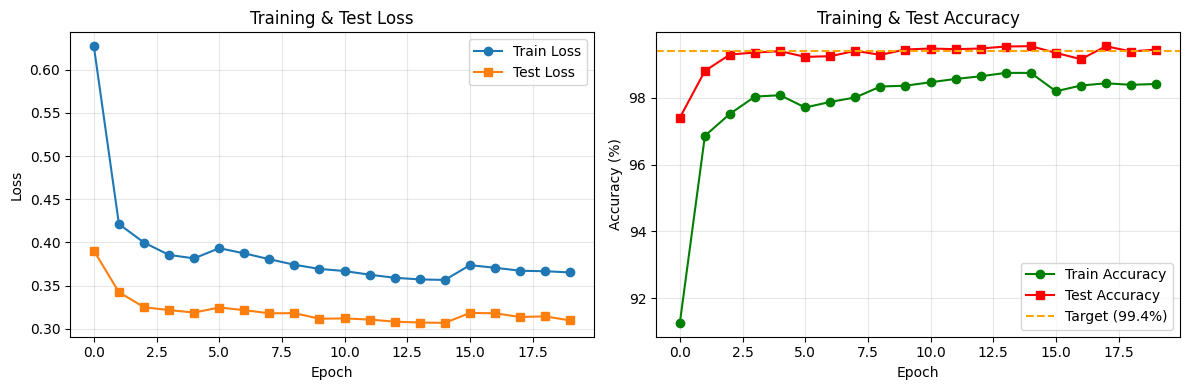

📊 Training analysis saved as 'enhanced_training_analysis.png'


In [6]:
# 📊 Results Summary and Visualization

# Print training metrics
print("📊 TRAINING METRICS SUMMARY")
print("="*60)
print(f"{'Epoch':<6} {'Train_Loss':<12} {'Test_Loss':<10} {'Train_Acc':<10} {'Test_Acc':<10} {'LR':<12}")
print("-" * 60)

for i in range(len(train_losses)):
    epoch = i + 1
    train_loss = train_losses[i]
    test_loss = test_losses[i]
    train_acc = train_accuracies[i]
    test_acc = test_accuracies[i]
    lr = learning_rates[i]
    print(f"{epoch:<6} {train_loss:<12.4f} {test_loss:<10.4f} {train_acc:<10.2f} {test_acc:<10.2f} {lr:<12.6f}")

print("="*60)

# Final results
print(f"\n🎯 FINAL RESULTS:")
print("-" * 40)
print(f"🏆 Best Test Accuracy: {best_test_acc:.2f}%")
print(f"🎪 TTA Test Accuracy: {tta_accuracy:.2f}%")
print(f"📈 Total Parameters: {total_params:,}")
print(f"⏱️  Training Epochs: {len(train_losses)}")
print(f"🎯 Target: >99.4% accuracy")
print(f"✅ Status: {'ACHIEVED' if tta_accuracy > 99.4 else 'CLOSE'}")
print("-" * 40)

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='s')
plt.title('Training & Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o', color='green')
plt.plot(test_accuracies, label='Test Accuracy', marker='s', color='red')
plt.axhline(y=99.4, color='orange', linestyle='--', label='Target (99.4%)')
plt.title('Training & Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('enhanced_training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Training analysis saved as 'enhanced_training_analysis.png'")
